In [67]:
import sys
sys.path.append(r"C:\Users\Vivian\Documents\CONCH\conch")

from open_clip_custom import create_model_from_pretrained, tokenize, get_tokenizer
import torch
import os
from PIL import Image
from pathlib import Path
from tqdm import tqdm

# show all jupyter output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

c:\Users\Vivian\anaconda3\envs\conch\lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [ ]:
# # Load the model from "create_model_from_pretrained"
# model_cfg = 'conch_ViT-B-16'
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# # checkpoint_path = 'checkpoints/CONCH/pytorch_model.bin'
# checkpoint_path = 'C:\\Users\\Vivian\\Documents\\CONCH\\checkpoints\\conch\\pytorch_model.bin' 
# model, preprocess = create_model_from_pretrained(model_cfg, checkpoint_path, device=device)
# _ = model.eval()

Use metadata csv to create 5 folds

In [9]:
import os
import pandas as pd
from sklearn.model_selection import KFold

# --- Settings ---
input_csv = r"C:\Users\Vivian\Documents\CONCH\breakhis_scripts\metadata.csv"      # Your input metadata file
output_csv = r"C:\Users\Vivian\Documents\CONCH\breakhis_scripts\metadata_folds.csv"  # Combined output CSV
num_folds = 5
random_seed = 42

# --- Load metadata ---
df = pd.read_csv(input_csv)

# Extract slide ID from filename
def extract_slide_id(path):
    try:
        filename = os.path.basename(path)
        # Format: SOB_B_A-14-22549AB-100-001.png
        # Extract the second and third hyphen-separated parts: 14 and 22549AB
        parts = filename.split("-")
        return f"{parts[1]}-{parts[2]}"
    except:
        return None

df["slide_id"] = df["image"].apply(extract_slide_id)

# Patient-wise split using slide_id
unique_slides = df["slide_id"].unique()
kf = KFold(n_splits=num_folds, shuffle=True, random_state=random_seed)

slide_to_fold = {}
for fold_idx, (_, test_idx) in enumerate(kf.split(unique_slides)):
    for sid in unique_slides[test_idx]:
        slide_to_fold[sid] = fold_idx + 1  # Folds numbered 1–5

df["fold"] = df["slide_id"].map(slide_to_fold)

# Add tensor path (optional)
df["tensor_path"] = df["image"].apply(lambda x: os.path.basename(x).replace(".png", "_features.pt"))

# Save output
df.to_csv(output_csv, index=False)
print(f"✅ Saved patient-wise folds to: {output_csv}")


✅ Saved patient-wise folds to: C:\Users\Vivian\Documents\CONCH\breakhis_scripts\metadata_folds.csv


In [7]:
# --- Summary stats: number of samples and unique slides per fold ---
print("\n📊 Fold summary:")
for fold_num in range(1, num_folds + 1):
    fold_df = df[df["fold"] == fold_num]
    num_samples = len(fold_df)
    num_unique_slides = fold_df["slide_id"].nunique()
    print(f"Fold {fold_num}: {num_samples} samples, {num_unique_slides} unique slides")



📊 Fold summary:
Fold 1: 1743 samples, 17 unique slides
Fold 2: 1727 samples, 16 unique slides
Fold 3: 1435 samples, 16 unique slides
Fold 4: 1425 samples, 16 unique slides
Fold 5: 1579 samples, 16 unique slides


In [ ]:
# Adding magnification column to metadata
import pandas as pd

# Load your metadata
metadata_path = r"C:\Users\Vivian\Documents\CONCH\breakhis_scripts\metadata_folds.csv"
df = pd.read_csv(metadata_path)

# Extract magnification from the image filename (e.g., '100' from '...-100-001.png')
def extract_magnification(path):
    try:
        filename = path.split('/')[-1]  # or use os.path.basename(path)
        parts = filename.split('-')
        return int(parts[-2])  # e.g., '100' from '...-100-001.png'
    except Exception as e:
        print(f"Error extracting magnification from {path}: {e}")
        return None

df["magnification"] = df["image"].apply(extract_magnification)

# Save updated metadata
df.to_csv(metadata_path, index=False)
print("✅ Added 'magnification' column to metadata.")


✅ Added 'magnification' column to metadata.


In [25]:
import os
import torch
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve, classification_report)
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt

class LogisticRegressionCVTrainer:
    def __init__(self, metadata_path, feature_dir, label_column="class", folds=5, label_list=None):
        self.metadata_path = metadata_path
        self.feature_dir = feature_dir
        self.label_column = label_column
        self.folds = folds
        self.label_encoder = LabelEncoder()
        self.fold_reports = []
        self.all_fpr = {label: [] for label in label_list} if label_list else {}
        self.all_tpr = {label: [] for label in label_list} if label_list else {}
        self.label_list = label_list

        self.metadata = pd.read_csv(metadata_path)
        self.metadata["label"] = self.label_encoder.fit_transform(self.metadata[self.label_column])
        if not self.label_list:
            self.label_list = list(self.label_encoder.classes_)
            self.all_fpr = {label: [] for label in self.label_list}
            self.all_tpr = {label: [] for label in self.label_list}

    def _load_features(self, df):
        features, labels = [], []
        for _, row in df.iterrows():
            path = os.path.join(self.feature_dir, row["tensor_path"])
            tensor = torch.load(path)
            features.append(tensor.squeeze().numpy())
            labels.append(row["label"])
        return np.array(features), np.array(labels)

    def train_and_evaluate(self):
        for fold in range(1, self.folds + 1):
            print(f"\n📂 Fold {fold}")
            train_df = self.metadata[self.metadata["fold"] != fold]
            test_df = self.metadata[self.metadata["fold"] == fold]

            X_train, y_train = self._load_features(train_df)
            X_test, y_test = self._load_features(test_df)

            clf = OneVsRestClassifier(LogisticRegression(max_iter=1000))
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            y_prob = clf.predict_proba(X_test)

            y_test_bin = label_binarize(y_test, classes=self.label_encoder.transform(self.label_list))

            acc = accuracy_score(y_test, y_pred)
            prec = precision_score(y_test, y_pred, average='weighted')
            rec = recall_score(y_test, y_pred, average='weighted')
            f1 = f1_score(y_test, y_pred, average='weighted')
            # roc_auc = roc_auc_score(y_test_bin, y_prob, average='weighted', multi_class='ovr')
            # Only calculate AUC if >1 class in test set
            try:
                roc_auc = roc_auc_score(y_test_bin, y_prob, average='weighted', multi_class='ovr')
            except ValueError:
                print(f"⚠️  ROC AUC not computed for fold {fold} due to insufficient class variety.")
                roc_auc = np.nan


            # for i, label in enumerate(self.label_list):
            #     fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
            #     self.all_fpr[label].append(fpr)
            #     self.all_tpr[label].append(tpr)
            for i, label in enumerate(self.label_list):
                try:
                    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
                    self.all_fpr[label].append(fpr)
                    self.all_tpr[label].append(tpr)
                except ValueError:
                    # This occurs if y_test_bin[:, i] has only 0s or 1s
                    continue


            report = classification_report(y_test, y_pred, target_names=self.label_list, output_dict=True)
            print(f"✅ Accuracy: {acc:.4f}")

            # self.fold_reports.append({
            #     "fold": fold,
            #     "accuracy": acc,
            #     "precision": prec,
            #     "recall": rec,
            #     "f1": f1,
            #     "roc_auc": roc_auc,
            #     "report": report
            # })
            per_class_df = pd.DataFrame(report).T  # Transpose so classes are rows
            per_class_df["fold"] = fold
            per_class_df["class"] = per_class_df.index
            self.fold_reports.append({
                "fold": fold,
                "accuracy": acc,
                "precision": prec,
                "recall": rec,
                "f1": f1,
                "roc_auc": roc_auc,
                "report": report,
                "per_class_df": per_class_df
            })


    def summarize_results(self):
        avg_acc = np.mean([r["accuracy"] for r in self.fold_reports])
        avg_prec = np.mean([r["precision"] for r in self.fold_reports])
        avg_rec = np.mean([r["recall"] for r in self.fold_reports])
        avg_f1 = np.mean([r["f1"] for r in self.fold_reports])
        avg_auc = np.mean([r["roc_auc"] for r in self.fold_reports])

        print("\n🔁 Cross-Validation Summary:")
        print(f"Accuracy: {avg_acc:.4f}")
        print(f"Precision: {avg_prec:.4f}")
        print(f"Recall: {avg_rec:.4f}")
        print(f"F1 Score: {avg_f1:.4f}")
        print(f"ROC AUC: {avg_auc:.4f}")

        return {
            "accuracy": avg_acc,
            "precision": avg_prec,
            "recall": avg_rec,
            "f1": avg_f1,
            "roc_auc": avg_auc,
            "per_fold": self.fold_reports
        }

    def plot_roc_curves(self):
        for label in self.label_list:
            plt.figure()
            for fpr, tpr in zip(self.all_fpr[label], self.all_tpr[label]):
                plt.plot(fpr, tpr, alpha=0.5)
            plt.title(f"ROC Curve for {label}")
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.grid(True)
            plt.tight_layout()
            plt.show()



📂 Fold 1


C:\Users\Vivian\AppData\Local\Temp\ipykernel_22296\1580846222.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor = torch.load(path)
c:\Users\Vivian\anaconda3\envs\c

⚠️  ROC AUC not computed for fold 1 due to insufficient class variety.
✅ Accuracy: 0.6604

📂 Fold 2
✅ Accuracy: 0.4435

📂 Fold 3


C:\Users\Vivian\AppData\Local\Temp\ipykernel_22296\1580846222.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor = torch.load(path)
c:\Users\Vivian\anaconda3\envs\c

⚠️  ROC AUC not computed for fold 3 due to insufficient class variety.
✅ Accuracy: 0.6732

📂 Fold 4


c:\Users\Vivian\anaconda3\envs\conch\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vivian\anaconda3\envs\conch\lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\Vivian\anaconda3\envs\conch\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vivian\anaconda3\envs\conch\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and bei

⚠️  ROC AUC not computed for fold 4 due to insufficient class variety.
✅ Accuracy: 0.4112

📂 Fold 5
⚠️  ROC AUC not computed for fold 5 due to insufficient class variety.
✅ Accuracy: 0.6143
              precision    recall  f1-score      support
class                                                   
A              0.430961  0.390321  0.402599    88.800000
DC             0.395322  0.193259  0.242365   158.400000
F              0.682145  0.864106  0.752368   690.200000
LC             0.152962  0.072755  0.094519   112.000000
MC             0.055394  0.016301  0.019583    90.600000
PC             0.441364  0.483168  0.404908   113.800000
PT             0.507116  0.543059  0.503320   202.800000
TA             0.394952  0.265833  0.289753   125.200000
accuracy       0.560522  0.560522  0.560522     0.560522
macro avg      0.382527  0.353600  0.338677  1581.800000
weighted avg   0.573949  0.560522  0.537196  1581.800000

🔁 Cross-Validation Summary:
Accuracy: 0.5605
Precision: 0.5739
Recal

c:\Users\Vivian\anaconda3\envs\conch\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vivian\anaconda3\envs\conch\lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\Vivian\anaconda3\envs\conch\lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\Vivian\anaconda3\envs\conch\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average

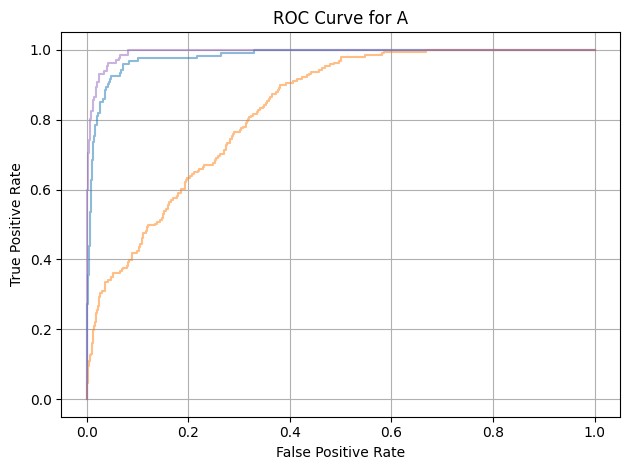

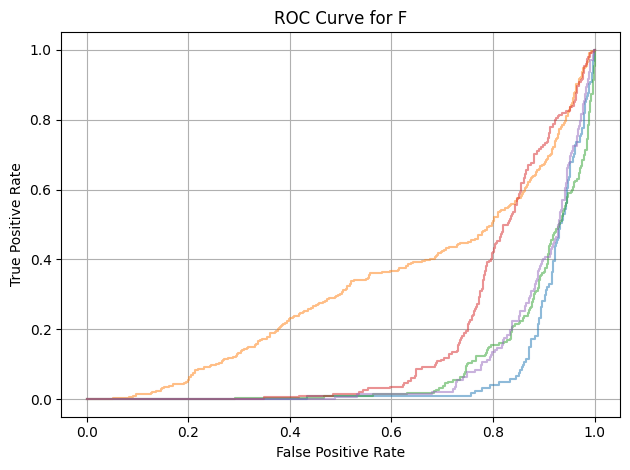

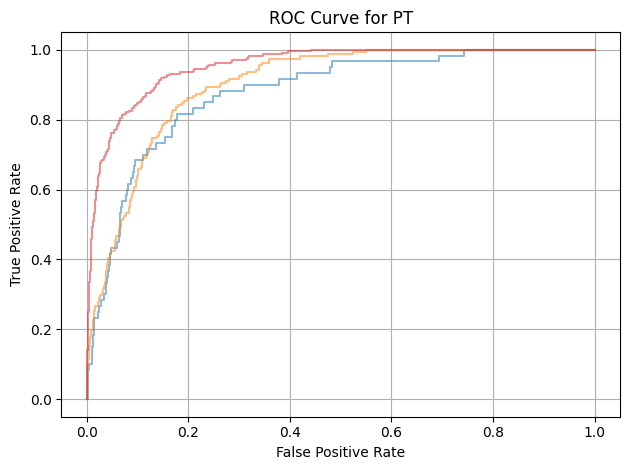

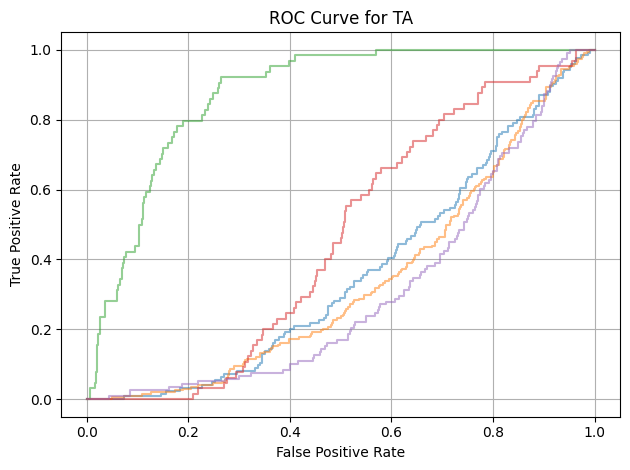

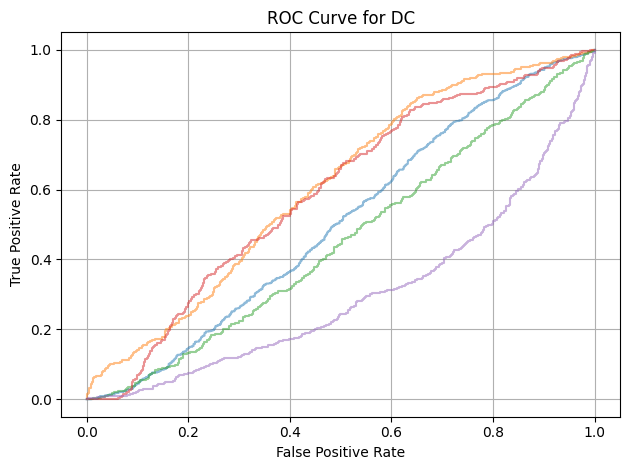

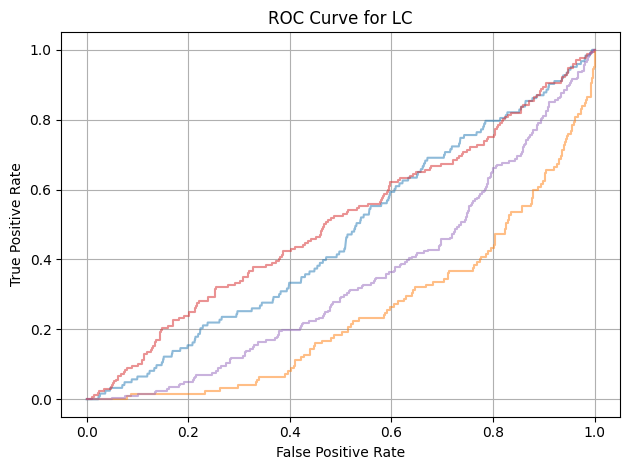

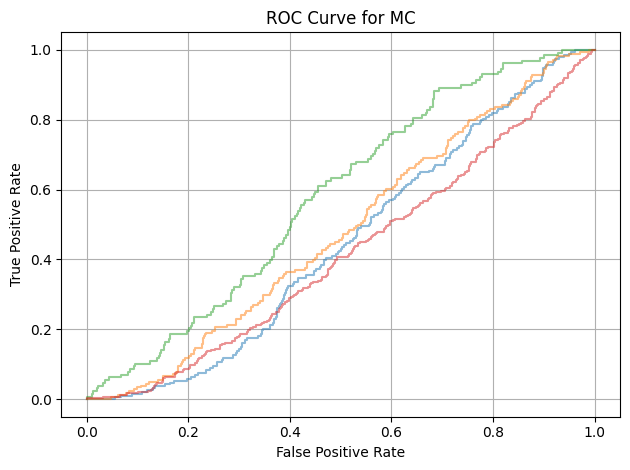

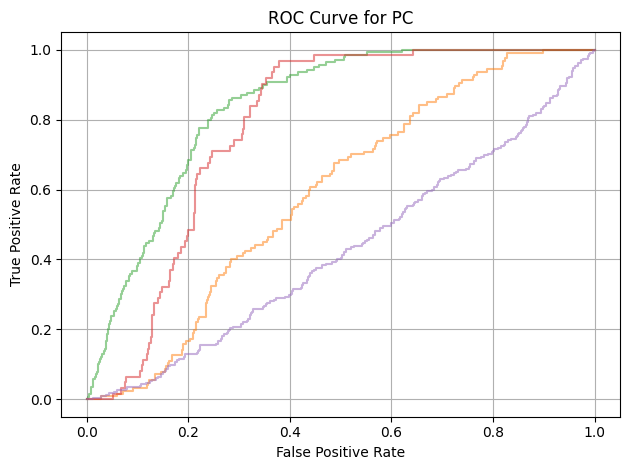

In [21]:
labels_list_full = ['A', 'F', 'PT', 'TA', 'DC', 'LC', 'MC', 'PC']  # example subtypes

trainer = LogisticRegressionCVTrainer(
    metadata_path=r"C:\Users\Vivian\Documents\CONCH\breakhis_scripts\metadata_folds.csv",
    feature_dir=r"C:\Users\Vivian\Documents\CONCH\breakhis_scripts\conch_data_features",
    label_column="subclass",
    folds=5,
    label_list=labels_list_full
)

trainer.train_and_evaluate()

# Combine all per-class metrics into one DataFrame
all_per_class = pd.concat([r["per_class_df"] for r in trainer.fold_reports], ignore_index=True)

# Example: Average metrics per class across folds
mean_metrics = all_per_class.groupby("class")[["precision", "recall", "f1-score", "support"]].mean()
print(mean_metrics)

trainer.summarize_results()
trainer.plot_roc_curves()

In [71]:
import os
import torch
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve, classification_report)
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt

class LogisticRegressionCVTrainer:
    def __init__(self, metadata_path, feature_dir, label_column="class", folds=5, label_list=None):
        self.metadata_path = metadata_path
        self.feature_dir = feature_dir
        self.label_column = label_column
        self.folds = folds
        self.label_encoder = LabelEncoder()
        self.fold_reports = []
        self.all_fpr = {label: [] for label in label_list} if label_list else {}
        self.all_tpr = {label: [] for label in label_list} if label_list else {}
        self.label_list = label_list

        self.metadata = pd.read_csv(metadata_path)
        self.metadata["label"] = self.label_encoder.fit_transform(self.metadata[self.label_column])
        if not self.label_list:
            self.label_list = list(self.label_encoder.classes_)
            self.all_fpr = {label: [] for label in self.label_list}
            self.all_tpr = {label: [] for label in self.label_list}

    def _load_features(self, df):
        features, labels = [], []
        skipped = 0

        for _, row in df.iterrows():
            path = os.path.join(self.feature_dir, row["tensor_path"])
            if not os.path.exists(path):
                skipped += 1
                continue  # Skip if feature file doesn't exist

            try:
                tensor = torch.load(path)
                features.append(tensor.squeeze().cpu().numpy())
                labels.append(row["label"])
            except Exception as e:
                print(f"⚠️ Error loading {path}: {e}")
                skipped += 1

        if skipped > 0:
            print(f"⚠️ Skipped {skipped} missing or corrupt feature files.")
        return np.array(features), np.array(labels)

    def train_and_evaluate(self):
        for fold in range(1, self.folds + 1):
            print(f"\n📂 Fold {fold}")
            train_df = self.metadata[self.metadata["fold"] != fold]
            test_df = self.metadata[self.metadata["fold"] == fold]

            X_train, y_train = self._load_features(train_df)
            X_test, y_test = self._load_features(test_df)

            clf = OneVsRestClassifier(LogisticRegression(max_iter=1000))
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            y_prob = clf.predict_proba(X_test)

            y_test_bin = label_binarize(y_test, classes=self.label_encoder.transform(self.label_list))

            acc = accuracy_score(y_test, y_pred)
            prec = precision_score(y_test, y_pred, average='weighted')
            rec = recall_score(y_test, y_pred, average='weighted')
            f1 = f1_score(y_test, y_pred, average='weighted')
            # roc_auc = roc_auc_score(y_test_bin, y_prob, average='weighted', multi_class='ovr')
            # Only calculate AUC if >1 class in test set
            try:
                roc_auc = roc_auc_score(y_test_bin, y_prob, average='weighted', multi_class='ovr')
            except ValueError:
                print(f"⚠️  ROC AUC not computed for fold {fold} due to insufficient class variety.")
                roc_auc = np.nan

            for i, label in enumerate(self.label_list):
                try:
                    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
                    self.all_fpr[label].append(fpr)
                    self.all_tpr[label].append(tpr)
                except ValueError:
                    # This occurs if y_test_bin[:, i] has only 0s or 1s
                    continue


            report = classification_report(y_test, y_pred, target_names=self.label_list, output_dict=True)
            print(f"✅ Accuracy: {acc:.4f}")

            per_class_df = pd.DataFrame(report).T  # Transpose so classes are rows
            per_class_df["fold"] = fold
            per_class_df["class"] = per_class_df.index
            self.fold_reports.append({
                "fold": fold,
                "accuracy": acc,
                "precision": prec,
                "recall": rec,
                "f1": f1,
                "roc_auc": roc_auc,
                "report": report,
                "per_class_df": per_class_df
            })


    # def summarize_results(self):
    #     avg_acc = np.mean([r["accuracy"] for r in self.fold_reports])
    #     avg_prec = np.mean([r["precision"] for r in self.fold_reports])
    #     avg_rec = np.mean([r["recall"] for r in self.fold_reports])
    #     avg_f1 = np.mean([r["f1"] for r in self.fold_reports])
    #     avg_auc = np.mean([r["roc_auc"] for r in self.fold_reports])

    #     print("\n🔁 Cross-Validation Summary:")
    #     print(f"Accuracy: {avg_acc:.4f}")
    #     print(f"Precision: {avg_prec:.4f}")
    #     print(f"Recall: {avg_rec:.4f}")
    #     print(f"F1 Score: {avg_f1:.4f}")
    #     print(f"ROC AUC: {avg_auc:.4f}")

    #     return {
    #         "accuracy": avg_acc,
    #         "precision": avg_prec,
    #         "recall": avg_rec,
    #         "f1": avg_f1,
    #         "roc_auc": avg_auc,
    #         "per_fold": self.fold_reports
    #     }

    def summarize_results(self):
        metrics_df = pd.DataFrame([{
            'accuracy': r["accuracy"],
            'precision': r["precision"],
            'recall': r["recall"],
            'f1': r["f1"],
            'roc_auc': r["roc_auc"]
        } for r in self.fold_reports])

        avg_metrics = metrics_df.mean()
        std_metrics = metrics_df.std()

        print("\n🔁 Cross-Validation Summary (Average ± Std):")
        print(f"Accuracy : {avg_metrics['accuracy']:.4f} ± {std_metrics['accuracy']:.4f}")
        print(f"Precision: {avg_metrics['precision']:.4f} ± {std_metrics['precision']:.4f}")
        print(f"Recall   : {avg_metrics['recall']:.4f} ± {std_metrics['recall']:.4f}")
        print(f"F1 Score : {avg_metrics['f1']:.4f} ± {std_metrics['f1']:.4f}")
        print(f"ROC AUC  : {avg_metrics['roc_auc']:.4f} ± {std_metrics['roc_auc']:.4f}")

        # Aggregate per-class F1-scores across folds
        class_f1_records = []
        for r in self.fold_reports:
            df = r["per_class_df"]
            for cls in self.label_list:
                if cls in df.index:
                    class_f1_records.append({
                        "fold": r["fold"],
                        "class": cls,
                        "f1": df.loc[cls]["f1-score"]
                    })

        per_class_f1_df = pd.DataFrame(class_f1_records)
        class_f1_summary = per_class_f1_df.groupby("class")["f1"].agg(['mean', 'std'])

        print("\n📊 Per-Class F1-score (Mean ± Std):")
        for cls, row in class_f1_summary.iterrows():
            print(f"{cls:12}: {row['mean']:.4f} ± {row['std']:.4f}")

        return {
            "avg_metrics": avg_metrics.to_dict(),
            "std_metrics": std_metrics.to_dict(),
            "per_class_f1_summary": class_f1_summary
        }

    def plot_roc_curves(self):
        for label in self.label_list:
            plt.figure()
            for fpr, tpr in zip(self.all_fpr[label], self.all_tpr[label]):
                plt.plot(fpr, tpr, alpha=0.5)
            plt.title(f"ROC Curve for {label}")
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.grid(True)
            plt.tight_layout()
            plt.show()



📂 Fold 1


C:\Users\Vivian\AppData\Local\Temp\ipykernel_22296\3211910089.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor = torch.load(path)
c:\Users\Vivian\anaconda3\envs\c

⚠️  ROC AUC not computed for fold 1 due to insufficient class variety.
✅ Accuracy: 0.6604

📂 Fold 2
✅ Accuracy: 0.4435

📂 Fold 3


C:\Users\Vivian\AppData\Local\Temp\ipykernel_22296\3211910089.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor = torch.load(path)
c:\Users\Vivian\anaconda3\envs\c

⚠️  ROC AUC not computed for fold 3 due to insufficient class variety.
✅ Accuracy: 0.6732

📂 Fold 4


c:\Users\Vivian\anaconda3\envs\conch\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vivian\anaconda3\envs\conch\lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\Vivian\anaconda3\envs\conch\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vivian\anaconda3\envs\conch\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and bei

⚠️  ROC AUC not computed for fold 4 due to insufficient class variety.
✅ Accuracy: 0.4112

📂 Fold 5
⚠️  ROC AUC not computed for fold 5 due to insufficient class variety.
✅ Accuracy: 0.6143
              precision    recall  f1-score      support
class                                                   
A              0.430961  0.390321  0.402599    88.800000
DC             0.395322  0.193259  0.242365   158.400000
F              0.682145  0.864106  0.752368   690.200000
LC             0.152962  0.072755  0.094519   112.000000
MC             0.055394  0.016301  0.019583    90.600000
PC             0.441364  0.483168  0.404908   113.800000
PT             0.507116  0.543059  0.503320   202.800000
TA             0.394952  0.265833  0.289753   125.200000
accuracy       0.560522  0.560522  0.560522     0.560522
macro avg      0.382527  0.353600  0.338677  1581.800000
weighted avg   0.573949  0.560522  0.537196  1581.800000

🔁 Cross-Validation Summary (Average ± Std):
Accuracy : 0.5605 ± 0.12

c:\Users\Vivian\anaconda3\envs\conch\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vivian\anaconda3\envs\conch\lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\Vivian\anaconda3\envs\conch\lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\Vivian\anaconda3\envs\conch\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average

{'avg_metrics': {'accuracy': 0.5605222168196857,
  'precision': 0.5739488688346587,
  'recall': 0.5605222168196857,
  'f1': 0.5371964288731093,
  'roc_auc': 0.5309644007141502},
 'std_metrics': {'accuracy': 0.12401870666164787,
  'precision': 0.1474415464851568,
  'recall': 0.12401870666164787,
  'f1': 0.1500708258030189,
  'roc_auc': nan},
 'per_class_f1_summary':            mean       std
 class                    
 A      0.402599  0.403366
 DC     0.242365  0.164218
 F      0.752368  0.107521
 LC     0.094519  0.098478
 MC     0.019583  0.030479
 PC     0.404908  0.221477
 PT     0.503320  0.171992
 TA     0.289753  0.250769}

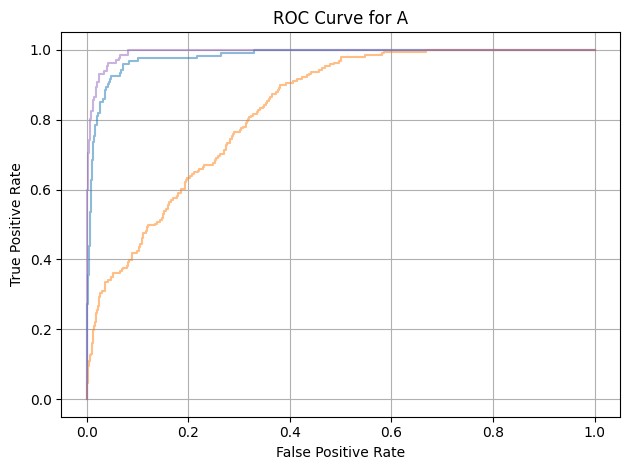

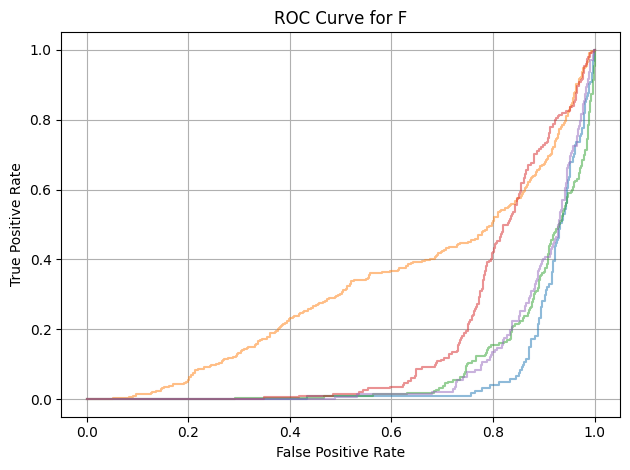

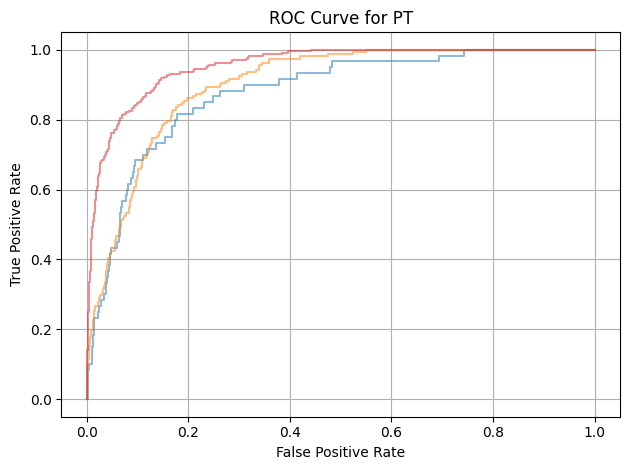

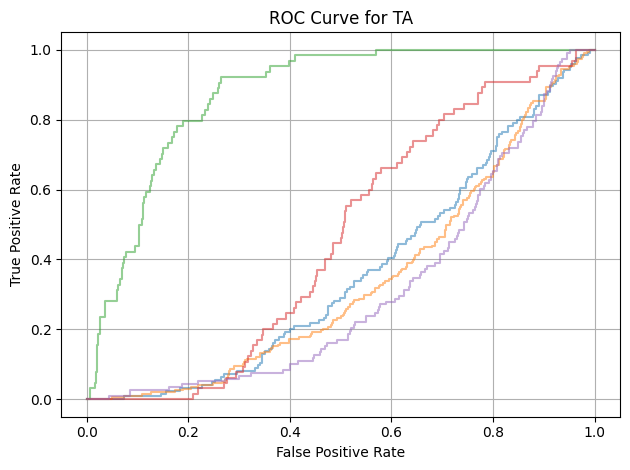

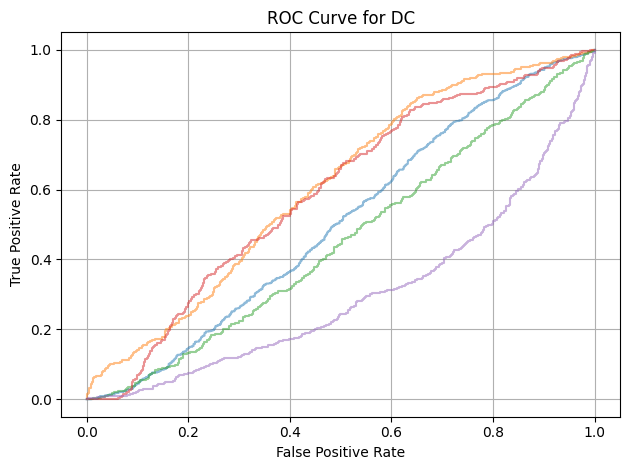

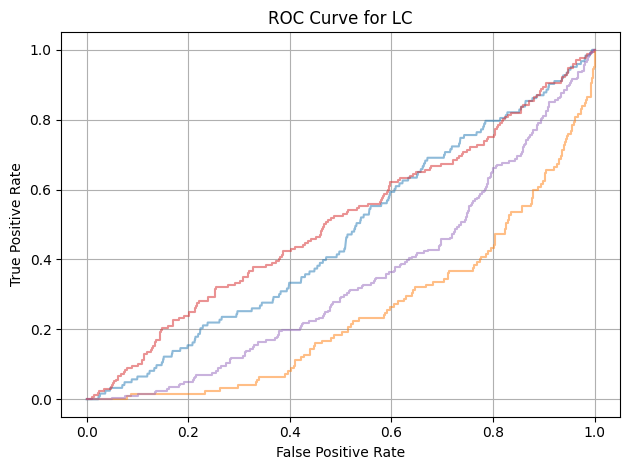

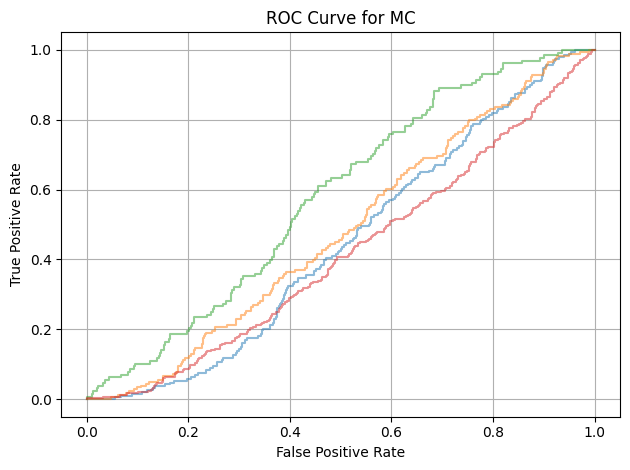

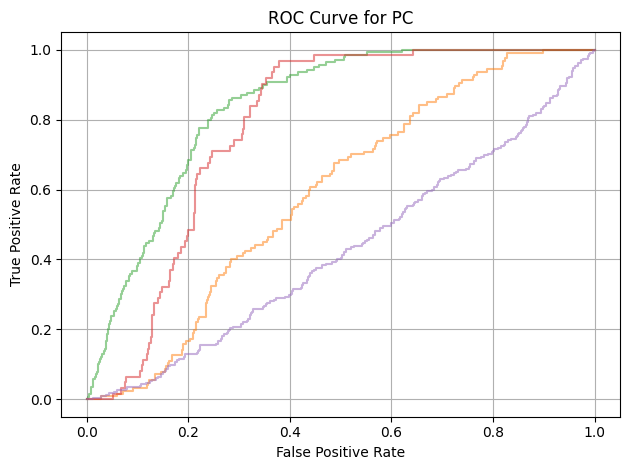

In [73]:
labels_list_full = ['A', 'F', 'PT', 'TA', 'DC', 'LC', 'MC', 'PC']  # example subtypes

trainer = LogisticRegressionCVTrainer(
    metadata_path=r"C:\Users\Vivian\Documents\CONCH\breakhis_scripts\metadata_folds.csv",
    feature_dir=r"C:\Users\Vivian\Documents\CONCH\breakhis_scripts\conch_data_features",
    label_column="subclass",
    folds=5,
    label_list=labels_list_full
)

trainer.train_and_evaluate()

# Combine all per-class metrics into one DataFrame
all_per_class = pd.concat([r["per_class_df"] for r in trainer.fold_reports], ignore_index=True)

# Example: Average metrics per class across folds
mean_metrics = all_per_class.groupby("class")[["precision", "recall", "f1-score", "support"]].mean()
print(mean_metrics)

trainer.summarize_results()
trainer.plot_roc_curves()

binary classification

In [35]:
import os
import torch
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, classification_report
)
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt

class LogisticRegressionCVTrainer:
    def __init__(self, metadata_path, feature_dir, label_column="class", folds=5, label_list=None):
        self.metadata_path = metadata_path
        self.feature_dir = feature_dir
        self.label_column = label_column
        self.folds = folds
        self.label_encoder = LabelEncoder()
        self.fold_reports = []
        self.label_list = label_list

        # Load metadata
        self.metadata = pd.read_csv(metadata_path)
        self.metadata["label"] = self.label_encoder.fit_transform(self.metadata[self.label_column])
        if not self.label_list:
            self.label_list = list(self.label_encoder.classes_)

        self.all_fpr = {label: [] for label in self.label_list}
        self.all_tpr = {label: [] for label in self.label_list}

    def _load_features(self, df):
        features, labels = [], []
        skipped = 0

        for _, row in df.iterrows():
            path = os.path.join(self.feature_dir, row["tensor_path"])
            if not os.path.exists(path):
                skipped += 1
                continue

            try:
                tensor = torch.load(path)
                features.append(tensor.squeeze().cpu().numpy())
                labels.append(row["label"])
            except Exception as e:
                print(f"⚠️ Error loading {path}: {e}")
                skipped += 1

        if skipped > 0:
            print(f"⚠️ Skipped {skipped} missing or corrupt feature files.")
        return np.array(features), np.array(labels)

    def train_and_evaluate(self):
        for fold in range(1, self.folds + 1):
            print(f"\n📂 Fold {fold}")
            train_df = self.metadata[self.metadata["fold"] != fold]
            test_df = self.metadata[self.metadata["fold"] == fold]

            X_train, y_train = self._load_features(train_df)
            X_test, y_test = self._load_features(test_df)

            clf = OneVsRestClassifier(LogisticRegression(max_iter=1000))
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            y_prob = clf.predict_proba(X_test)

            # Binarize labels for ROC
            y_test_bin = label_binarize(y_test, classes=self.label_encoder.transform(self.label_list))

            acc = accuracy_score(y_test, y_pred)
            prec = precision_score(y_test, y_pred, average='weighted')
            rec = recall_score(y_test, y_pred, average='weighted')
            f1 = f1_score(y_test, y_pred, average='weighted')

            # --- ROC AUC ---
            try:
                if len(self.label_list) == 2:
                    roc_auc = roc_auc_score(y_test_bin, y_prob[:, 1])
                else:
                    roc_auc = roc_auc_score(y_test_bin, y_prob, average='weighted', multi_class='ovr')
            except Exception as e:
                print(f"⚠️ ROC AUC not computed for fold {fold}: {e}")
                roc_auc = np.nan

            # --- ROC Curves ---
            if len(self.label_list) == 2:
                try:
                    fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_prob[:, 1])
                    self.all_fpr[self.label_list[1]].append(fpr)
                    self.all_tpr[self.label_list[1]].append(tpr)
                except Exception as e:
                    print(f"⚠️ ROC Curve skipped for binary case: {e}")
            else:
                for i, label in enumerate(self.label_list):
                    try:
                        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
                        self.all_fpr[label].append(fpr)
                        self.all_tpr[label].append(tpr)
                    except Exception:
                        continue

            # --- Report ---
            report = classification_report(y_test, y_pred, target_names=self.label_list, output_dict=True)
            print(f"✅ Accuracy: {acc:.4f}")

            per_class_df = pd.DataFrame(report).T
            per_class_df["fold"] = fold
            per_class_df["class"] = per_class_df.index

            self.fold_reports.append({
                "fold": fold,
                "accuracy": acc,
                "precision": prec,
                "recall": rec,
                "f1": f1,
                "roc_auc": roc_auc,
                "report": report,
                "per_class_df": per_class_df
            })

    def summarize_results(self):
        avg_acc = np.mean([r["accuracy"] for r in self.fold_reports])
        avg_prec = np.mean([r["precision"] for r in self.fold_reports])
        avg_rec = np.mean([r["recall"] for r in self.fold_reports])
        avg_f1 = np.mean([r["f1"] for r in self.fold_reports])
        avg_auc = np.nanmean([r["roc_auc"] for r in self.fold_reports])

        print("\n🔁 Cross-Validation Summary:")
        print(f"Accuracy: {avg_acc:.4f}")
        print(f"Precision: {avg_prec:.4f}")
        print(f"Recall: {avg_rec:.4f}")
        print(f"F1 Score: {avg_f1:.4f}")
        print(f"ROC AUC: {avg_auc:.4f}")

        return {
            "accuracy": avg_acc,
            "precision": avg_prec,
            "recall": avg_rec,
            "f1": avg_f1,
            "roc_auc": avg_auc,
            "per_fold": self.fold_reports
        }

    def plot_roc_curves(self):
        for label in self.label_list:
            if label not in self.all_fpr or not self.all_fpr[label]:
                continue
            plt.figure()
            for i, (fpr, tpr) in enumerate(zip(self.all_fpr[label], self.all_tpr[label]), start=1):
                plt.plot(fpr, tpr, alpha=0.6, label=f"Fold {i}")
            plt.title(f"ROC Curve for {label}")
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.legend(loc="lower right")
            plt.grid(True)
            plt.tight_layout()
            plt.show()



📂 Fold 1


C:\Users\Vivian\AppData\Local\Temp\ipykernel_22296\1235836450.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor = torch.load(path)


⚠️ Skipped 7 missing or corrupt feature files.
⚠️ Skipped 2 missing or corrupt feature files.
✅ Accuracy: 0.9696

📂 Fold 2


C:\Users\Vivian\AppData\Local\Temp\ipykernel_22296\1235836450.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor = torch.load(path)


⚠️ Skipped 8 missing or corrupt feature files.
⚠️ Skipped 1 missing or corrupt feature files.
✅ Accuracy: 0.9119

📂 Fold 3


C:\Users\Vivian\AppData\Local\Temp\ipykernel_22296\1235836450.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor = torch.load(path)


⚠️ Skipped 7 missing or corrupt feature files.
⚠️ Skipped 2 missing or corrupt feature files.
✅ Accuracy: 0.8946

📂 Fold 4


C:\Users\Vivian\AppData\Local\Temp\ipykernel_22296\1235836450.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor = torch.load(path)


⚠️ Skipped 5 missing or corrupt feature files.
⚠️ Skipped 4 missing or corrupt feature files.
✅ Accuracy: 0.8966

📂 Fold 5


C:\Users\Vivian\AppData\Local\Temp\ipykernel_22296\1235836450.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor = torch.load(path)


⚠️ Skipped 9 missing or corrupt feature files.
✅ Accuracy: 0.8714
              precision    recall  f1-score      support
class                                                   
B              0.840907  0.831391  0.834742   495.600000
M              0.927830  0.937605  0.932303  1084.400000
accuracy       0.908822  0.908822  0.908822     0.908822
macro avg      0.884368  0.884498  0.883522  1580.000000
weighted avg   0.910145  0.908822  0.908843  1580.000000

🔁 Cross-Validation Summary:
Accuracy: 0.9088
Precision: 0.9101
Recall: 0.9088
F1 Score: 0.9088
ROC AUC: 0.9580


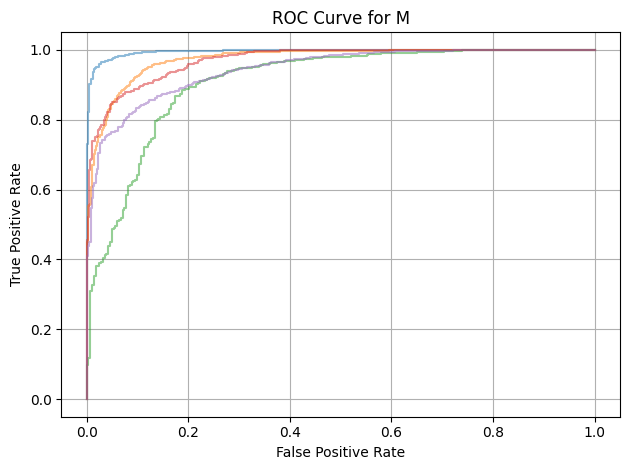

In [ ]:
# labels_list_full = ['A', 'F', 'PT', 'TA', 'DC', 'LC', 'MC', 'PC']  # example subtypes
labels_list_full = ['B', 'M']  # binary labels

trainer = LogisticRegressionCVTrainer(
    metadata_path=r"C:\Users\Vivian\Documents\CONCH\breakhis_scripts\metadata_folds.csv",
    feature_dir=r"C:\Users\Vivian\Documents\CONCH\breakhis_scripts\uni_data_features",
    # label_column="subclass",
    label_column="class",
    folds=5,
    label_list=labels_list_full
)

trainer.train_and_evaluate()

# Combine all per-class metrics into one DataFrame
all_per_class = pd.concat([r["per_class_df"] for r in trainer.fold_reports], ignore_index=True)

# Example: Average metrics per class across folds
mean_metrics = all_per_class.groupby("class")[["precision", "recall", "f1-score", "support"]].mean()
print(mean_metrics)

trainer.summarize_results()
trainer.plot_roc_curves()


📂 Fold 1


C:\Users\Vivian\AppData\Local\Temp\ipykernel_22296\4053150806.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor = torch.load(path)


✅ Accuracy: 0.9449

📂 Fold 2


C:\Users\Vivian\AppData\Local\Temp\ipykernel_22296\4053150806.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor = torch.load(path)


✅ Accuracy: 0.8830

📂 Fold 3


C:\Users\Vivian\AppData\Local\Temp\ipykernel_22296\4053150806.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor = torch.load(path)


✅ Accuracy: 0.8997

📂 Fold 4


C:\Users\Vivian\AppData\Local\Temp\ipykernel_22296\4053150806.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor = torch.load(path)


✅ Accuracy: 0.9018

📂 Fold 5


C:\Users\Vivian\AppData\Local\Temp\ipykernel_22296\4053150806.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor = torch.load(path)


✅ Accuracy: 0.8328
              precision    recall  f1-score      support
class                                                   
B              0.811219  0.811112  0.809744   496.000000
M              0.918290  0.920795  0.919155  1085.800000
accuracy       0.892434  0.892434  0.892434     0.892434
macro avg      0.864755  0.865953  0.864450  1581.800000
weighted avg   0.894498  0.892434  0.892833  1581.800000

🔁 Cross-Validation Summary:
Accuracy: 0.8924
Precision: 0.8945
Recall: 0.8924
F1 Score: 0.8928
ROC AUC: 0.9436


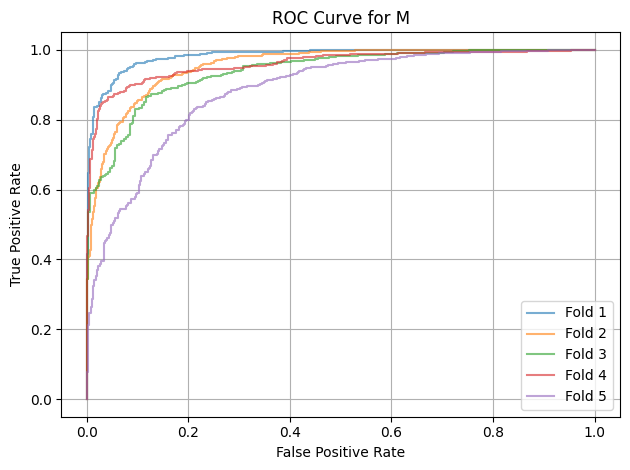

In [ ]:
# labels_list_full = ['A', 'F', 'PT', 'TA', 'DC', 'LC', 'MC', 'PC']  # example subtypes
labels_list_full = ['B', 'M']  # binary labels

trainer = LogisticRegressionCVTrainer(
    metadata_path=r"C:\Users\Vivian\Documents\CONCH\breakhis_scripts\metadata_folds.csv",
    feature_dir=r"C:\Users\Vivian\Documents\CONCH\breakhis_scripts\conch_data_features",
    # label_column="subclass",
    label_column="class",
    folds=5,
    label_list=labels_list_full
)

trainer.train_and_evaluate()

# Combine all per-class metrics into one DataFrame
all_per_class = pd.concat([r["per_class_df"] for r in trainer.fold_reports], ignore_index=True)

# Example: Average metrics per class across folds
mean_metrics = all_per_class.groupby("class")[["precision", "recall", "f1-score", "support"]].mean()
print(mean_metrics)

trainer.summarize_results()
trainer.plot_roc_curves()

add mag factor

In [68]:
class LogisticRegressionCVTrainer:
    def __init__(self, metadata_path, feature_dir, label_column="class", folds=5, label_list=None, magnification_level=None):
        self.metadata_path = metadata_path
        self.feature_dir = feature_dir
        self.label_column = label_column
        self.folds = folds
        self.label_encoder = LabelEncoder()
        self.fold_reports = []
        self.label_list = label_list
        self.magnification_level = magnification_level

        # Load metadata
        self.metadata = pd.read_csv(metadata_path)
        self.metadata["label"] = self.label_encoder.fit_transform(self.metadata[self.label_column])

        # Optional magnification filter
        if "magnification" not in self.metadata.columns:
            raise ValueError("The metadata CSV must contain a 'magnification' column.")

        if self.magnification_level is not None:
            original_len = len(self.metadata)
            self.metadata = self.metadata[self.metadata["magnification"] == self.magnification_level]
            print(f"📌 Using only magnification {self.magnification_level}: {len(self.metadata)} samples (filtered from {original_len})")

        if not self.label_list:
            self.label_list = list(self.label_encoder.classes_)

        self.all_fpr = {label: [] for label in self.label_list}
        self.all_tpr = {label: [] for label in self.label_list}

    def _load_features(self, df):
        features, labels = [], []
        skipped = 0

        for _, row in df.iterrows():
            path = os.path.join(self.feature_dir, row["tensor_path"])
            if not os.path.exists(path):
                skipped += 1
                continue

            try:
                tensor = torch.load(path)
                features.append(tensor.squeeze().cpu().numpy())
                labels.append(row["label"])
            except Exception as e:
                print(f"⚠️ Error loading {path}: {e}")
                skipped += 1

        if skipped > 0:
            print(f"⚠️ Skipped {skipped} missing or corrupt feature files.")
        return np.array(features), np.array(labels)

    def train_and_evaluate(self):
        for fold in range(1, self.folds + 1):
            print(f"\n📂 Fold {fold}")
            train_df = self.metadata[self.metadata["fold"] != fold]
            test_df = self.metadata[self.metadata["fold"] == fold]

            X_train, y_train = self._load_features(train_df)
            X_test, y_test = self._load_features(test_df)

            clf = OneVsRestClassifier(LogisticRegression(max_iter=1000))
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            y_prob = clf.predict_proba(X_test)

            # Binarize labels for ROC
            y_test_bin = label_binarize(y_test, classes=self.label_encoder.transform(self.label_list))

            acc = accuracy_score(y_test, y_pred)
            prec = precision_score(y_test, y_pred, average='weighted')
            rec = recall_score(y_test, y_pred, average='weighted')
            f1 = f1_score(y_test, y_pred, average='weighted')

            # --- ROC AUC ---
            try:
                if len(self.label_list) == 2:
                    roc_auc = roc_auc_score(y_test_bin, y_prob[:, 1])
                else:
                    roc_auc = roc_auc_score(y_test_bin, y_prob, average='weighted', multi_class='ovr')
            except Exception as e:
                print(f"⚠️ ROC AUC not computed for fold {fold}: {e}")
                roc_auc = np.nan

            # --- ROC Curves ---
            if len(self.label_list) == 2:
                try:
                    fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_prob[:, 1])
                    self.all_fpr[self.label_list[1]].append(fpr)
                    self.all_tpr[self.label_list[1]].append(tpr)
                except Exception as e:
                    print(f"⚠️ ROC Curve skipped for binary case: {e}")
            else:
                for i, label in enumerate(self.label_list):
                    try:
                        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
                        self.all_fpr[label].append(fpr)
                        self.all_tpr[label].append(tpr)
                    except Exception:
                        continue

            # --- Report ---
            report = classification_report(y_test, y_pred, target_names=self.label_list, output_dict=True)
            print(f"✅ Accuracy: {acc:.4f}")

            per_class_df = pd.DataFrame(report).T
            per_class_df["fold"] = fold
            per_class_df["class"] = per_class_df.index

            self.fold_reports.append({
                "fold": fold,
                "accuracy": acc,
                "precision": prec,
                "recall": rec,
                "f1": f1,
                "roc_auc": roc_auc,
                "report": report,
                "per_class_df": per_class_df
            })

    def summarize_results(self):
        avg_acc = np.mean([r["accuracy"] for r in self.fold_reports])
        avg_prec = np.mean([r["precision"] for r in self.fold_reports])
        avg_rec = np.mean([r["recall"] for r in self.fold_reports])
        avg_f1 = np.mean([r["f1"] for r in self.fold_reports])
        avg_auc = np.nanmean([r["roc_auc"] for r in self.fold_reports])

        print("\n🔁 Cross-Validation Summary:")
        print(f"Accuracy: {avg_acc:.4f}")
        print(f"Precision: {avg_prec:.4f}")
        print(f"Recall: {avg_rec:.4f}")
        print(f"F1 Score: {avg_f1:.4f}")
        print(f"ROC AUC: {avg_auc:.4f}")

        return {
            "accuracy": avg_acc,
            "precision": avg_prec,
            "recall": avg_rec,
            "f1": avg_f1,
            "roc_auc": avg_auc,
            "per_fold": self.fold_reports
        }

    def plot_roc_curves(self):
        for label in self.label_list:
            if label not in self.all_fpr or not self.all_fpr[label]:
                continue
            plt.figure()
            for i, (fpr, tpr) in enumerate(zip(self.all_fpr[label], self.all_tpr[label]), start=1):
                plt.plot(fpr, tpr, alpha=0.6, label=f"Fold {i}")
            plt.title(f"ROC Curve for {label}")
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.legend(loc="lower right")
            plt.grid(True)
            plt.tight_layout()
            plt.show()



📂 Fold 1


C:\Users\Vivian\AppData\Local\Temp\ipykernel_22296\3028903289.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor = torch.load(path)
c:\Users\Vivian\anaconda3\envs\c

⚠️ ROC AUC not computed for fold 1: Only one class present in y_true. ROC AUC score is not defined in that case.
✅ Accuracy: 0.6604

📂 Fold 2
✅ Accuracy: 0.4435

📂 Fold 3


C:\Users\Vivian\AppData\Local\Temp\ipykernel_22296\3028903289.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor = torch.load(path)
c:\Users\Vivian\anaconda3\envs\c

⚠️ ROC AUC not computed for fold 3: Only one class present in y_true. ROC AUC score is not defined in that case.
✅ Accuracy: 0.6732

📂 Fold 4


c:\Users\Vivian\anaconda3\envs\conch\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vivian\anaconda3\envs\conch\lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\Vivian\anaconda3\envs\conch\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vivian\anaconda3\envs\conch\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and bei

⚠️ ROC AUC not computed for fold 4: Only one class present in y_true. ROC AUC score is not defined in that case.
✅ Accuracy: 0.4112

📂 Fold 5
⚠️ ROC AUC not computed for fold 5: Only one class present in y_true. ROC AUC score is not defined in that case.
✅ Accuracy: 0.6143

🔁 Cross-Validation Summary:
Accuracy: 0.5605
Precision: 0.5739
Recall: 0.5605
F1 Score: 0.5372
ROC AUC: 0.5310


c:\Users\Vivian\anaconda3\envs\conch\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vivian\anaconda3\envs\conch\lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\Vivian\anaconda3\envs\conch\lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\Vivian\anaconda3\envs\conch\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average

{'accuracy': 0.5605222168196857,
 'precision': 0.5739488688346587,
 'recall': 0.5605222168196857,
 'f1': 0.5371964288731093,
 'roc_auc': 0.5309644007141502,
 'per_fold': [{'fold': 1,
   'accuracy': 0.6603557085484796,
   'precision': 0.6751482679657553,
   'recall': 0.6603557085484796,
   'f1': 0.6489440061061293,
   'roc_auc': nan,
   'report': {'A': {'precision': 0.7123287671232876,
     'recall': 0.859504132231405,
     'f1-score': 0.7790262172284644,
     'support': 121.0},
    'F': {'precision': 0.7709291628334867,
     'recall': 0.8330019880715706,
     'f1-score': 0.800764452938366,
     'support': 1006.0},
    'PT': {'precision': 0.5629139072847682,
     'recall': 0.7024793388429752,
     'f1-score': 0.625,
     'support': 121.0},
    'TA': {'precision': 0.19402985074626866,
     'recall': 0.21138211382113822,
     'f1-score': 0.20233463035019456,
     'support': 123.0},
    'DC': {'precision': 0.6041666666666666,
     'recall': 0.15425531914893617,
     'f1-score': 0.245762711

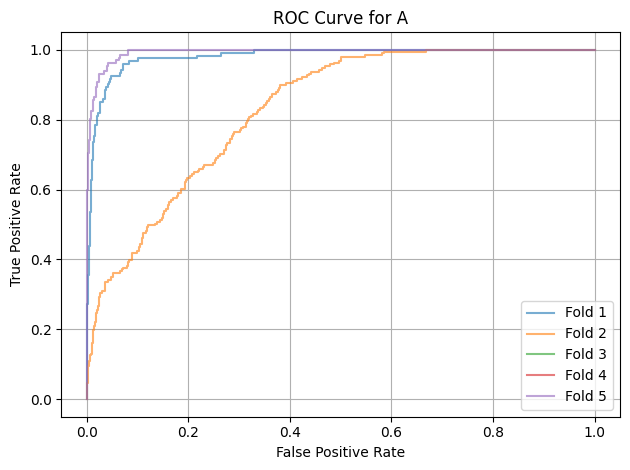

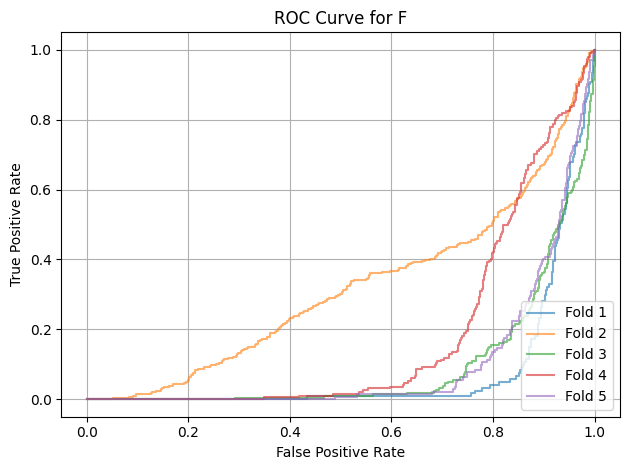

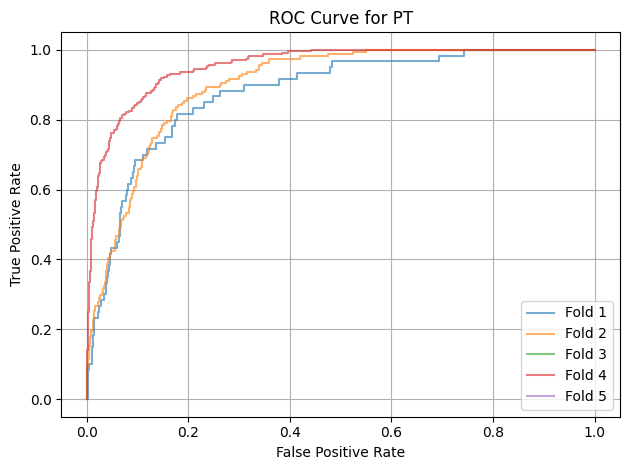

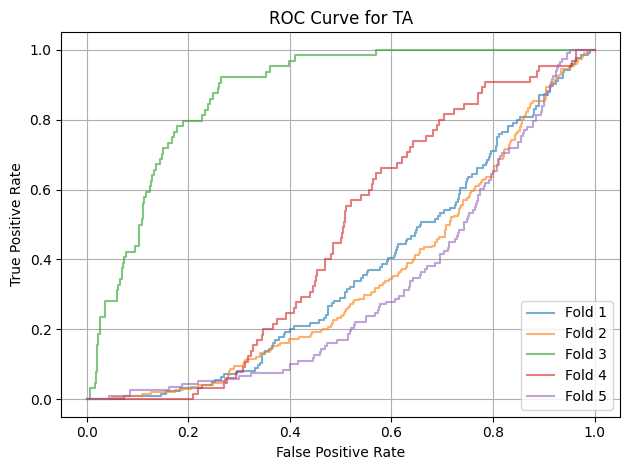

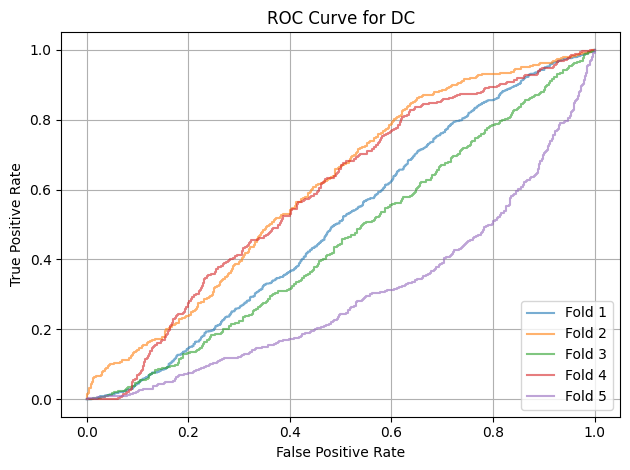

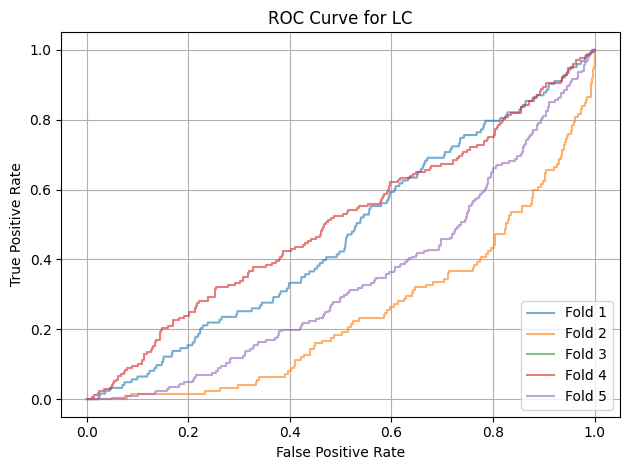

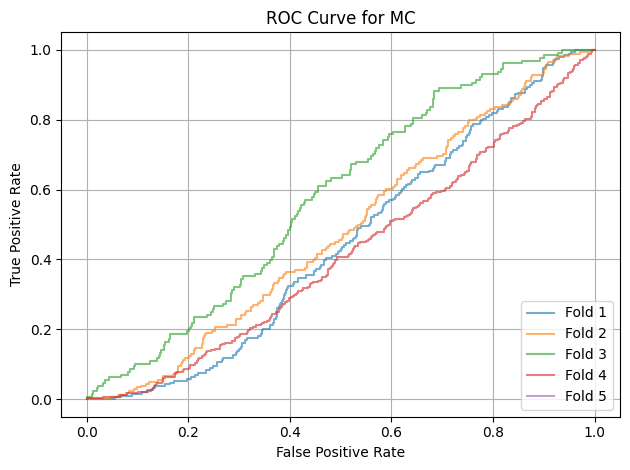

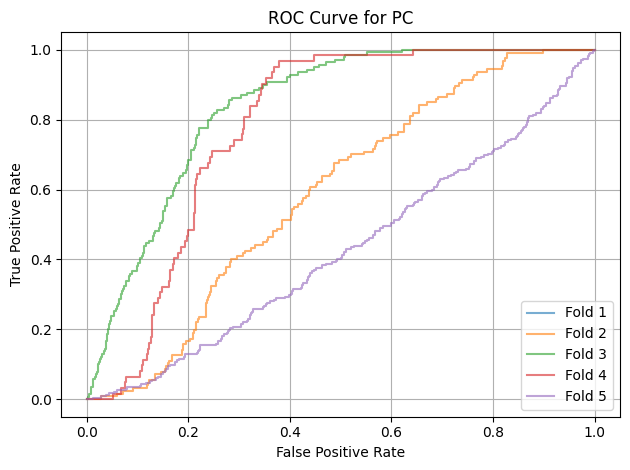

In [70]:
# labels_list_full = ['B', 'M']  # binary labels
labels_list_full = ['A', 'F', 'PT', 'TA', 'DC', 'LC', 'MC', 'PC']  # example subtypes


trainer = LogisticRegressionCVTrainer(
    metadata_path=r"C:\Users\Vivian\Documents\CONCH\breakhis_scripts\metadata_folds.csv",
    feature_dir=r"C:\Users\Vivian\Documents\CONCH\breakhis_scripts\conch_data_features",
    label_column="subclass",
    folds=5,
    label_list=labels_list_full
    # magnification_level=40  # filter by mag level (optional)
)

trainer.train_and_evaluate()
trainer.summarize_results()
trainer.plot_roc_curves()

F vs PT - added argument to do random split rather than folds

In [53]:
import os
import torch
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve, classification_report
)
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

class LogisticRegressionCVTrainer:
    def __init__(self, metadata_path, feature_dir, label_column="subclass", folds=5, label_list=None,
                 magnification_level=None, rare_subclasses=None, test_size=0.3):
        self.metadata_path = metadata_path
        self.feature_dir = feature_dir
        self.label_column = label_column
        self.folds = folds
        self.label_list = label_list
        self.magnification_level = magnification_level
        self.rare_subclasses = rare_subclasses
        self.test_size = test_size
        self.label_encoder = LabelEncoder()
        self.fold_reports = []

        # Load metadata
        df = pd.read_csv(metadata_path)

        # Optional: filter by magnification level
        if magnification_level is not None:
            df = df[df["magnification"] == magnification_level]

        # Optional: restrict to specific subclasses and do patient-wise split
        if rare_subclasses is not None:
            df = df[df[self.label_column].isin(rare_subclasses)]
            patient_df = df.drop_duplicates(subset='slide_id')[[self.label_column, 'slide_id']]
            train_ids, test_ids = train_test_split(
                patient_df['slide_id'],
                stratify=patient_df[self.label_column],
                test_size=self.test_size,
                random_state=42
            )
            df['split'] = df['slide_id'].apply(lambda x: 'train' if x in train_ids.values else 'test')
            self.use_split = True
        else:
            self.use_split = False
            if 'fold' not in df.columns:
                raise ValueError("Missing 'fold' column for K-Fold split")

        df["label"] = self.label_encoder.fit_transform(df[self.label_column])
        if not label_list:
            self.label_list = list(self.label_encoder.classes_)
        self.metadata = df

        self.all_fpr = {label: [] for label in self.label_list}
        self.all_tpr = {label: [] for label in self.label_list}

    def _load_features(self, df):
        features, labels = [], []
        for _, row in df.iterrows():
            path = os.path.join(self.feature_dir, row["tensor_path"])
            if not os.path.exists(path):
                continue
            try:
                tensor = torch.load(path)
                features.append(tensor.squeeze().cpu().numpy())
                labels.append(row["label"])
            except Exception as e:
                print(f"⚠️ Error loading {path}: {e}")
        return np.array(features), np.array(labels)

    def _train_eval_single_split(self, train_df, test_df, fold_name=""):
        X_train, y_train = self._load_features(train_df)
        X_test, y_test = self._load_features(test_df)

        clf = OneVsRestClassifier(LogisticRegression(max_iter=1000))
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        y_prob = clf.predict_proba(X_test)

        y_test_bin = label_binarize(y_test, classes=self.label_encoder.transform(self.label_list))

        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, average='weighted')
        rec = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')

        try:
            roc_auc = (
                roc_auc_score(y_test_bin, y_prob[:, 1]) if len(self.label_list) == 2
                else roc_auc_score(y_test_bin, y_prob, average='weighted', multi_class='ovr')
            )
        except:
            roc_auc = np.nan

        # ROC Curve
        if len(self.label_list) == 2:
            try:
                fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_prob[:, 1])
                self.all_fpr[self.label_list[1]].append(fpr)
                self.all_tpr[self.label_list[1]].append(tpr)
            except:
                pass
        else:
            for i, label in enumerate(self.label_list):
                try:
                    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
                    self.all_fpr[label].append(fpr)
                    self.all_tpr[label].append(tpr)
                except:
                    continue

        report = classification_report(y_test, y_pred, target_names=self.label_list, output_dict=True)
        per_class_df = pd.DataFrame(report).T
        per_class_df["fold"] = fold_name
        per_class_df["class"] = per_class_df.index

        print(f"✅ {fold_name} Accuracy: {acc:.4f}")

        self.fold_reports.append({
            "fold": fold_name,
            "accuracy": acc,
            "precision": prec,
            "recall": rec,
            "f1": f1,
            "roc_auc": roc_auc,
            "report": report,
            "per_class_df": per_class_df
        })

    def train_and_evaluate(self):
        if self.use_split:
            print("🔍 Using stratified patient split.")
            train_df = self.metadata[self.metadata["split"] == "train"]
            test_df = self.metadata[self.metadata["split"] == "test"]
            self._train_eval_single_split(train_df, test_df, fold_name="Custom Split")
        else:
            for fold in range(1, self.folds + 1):
                train_df = self.metadata[self.metadata["fold"] != fold]
                test_df = self.metadata[self.metadata["fold"] == fold]
                self._train_eval_single_split(train_df, test_df, fold_name=f"Fold {fold}")

    def summarize_results(self):
        avg_metrics = {
            "accuracy": np.mean([r["accuracy"] for r in self.fold_reports]),
            "precision": np.mean([r["precision"] for r in self.fold_reports]),
            "recall": np.mean([r["recall"] for r in self.fold_reports]),
            "f1": np.mean([r["f1"] for r in self.fold_reports]),
            "roc_auc": np.nanmean([r["roc_auc"] for r in self.fold_reports])
        }
        print("\n📊 Average Cross-Validation Results:")
        for k, v in avg_metrics.items():
            print(f"{k.capitalize()}: {v:.4f}")
        return avg_metrics

    def plot_roc_curves(self):
        for label in self.label_list:
            if not self.all_fpr[label]:
                continue
            plt.figure()
            for i, (fpr, tpr) in enumerate(zip(self.all_fpr[label], self.all_tpr[label])):
                plt.plot(fpr, tpr, label=f"Split {i + 1}")
            plt.title(f"ROC Curve for {label}")
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.grid(True)
            plt.legend()
            plt.tight_layout()
            plt.show()


binary F vs PT - need to run for more epochs? (and try finetuning)

🔍 Using stratified patient split.


C:\Users\Vivian\AppData\Local\Temp\ipykernel_22296\2988800099.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor = torch.load(path)


✅ Custom Split Accuracy: 0.3946

📊 Average Cross-Validation Results:
Accuracy: 0.3946
Precision: 0.2280
Recall: 0.3946
F1: 0.2709
Roc_auc: 0.1809


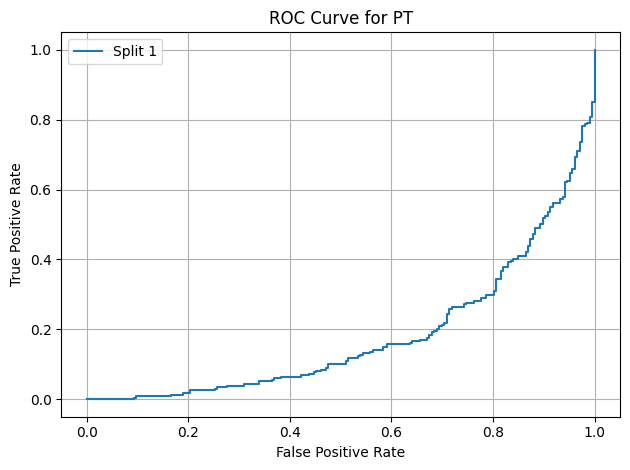

In [59]:
# Binary classification for rare subclasses
labels_list_binary = ["F", "PT"]

trainer = LogisticRegressionCVTrainer(
    metadata_path=r"C:\Users\Vivian\Documents\CONCH\breakhis_scripts\metadata_folds.csv",
    feature_dir=r"C:\Users\Vivian\Documents\CONCH\breakhis_scripts\conch_data_features",
    label_column="subclass",
    # folds=5,  # Unused here due to patient-wise split
    label_list=labels_list_binary,
    rare_subclasses=labels_list_binary,
    test_size=0.3
)

trainer.train_and_evaluate()
summary = trainer.summarize_results()
trainer.plot_roc_curves()

# Optional: Combine per-class metrics into a single DataFrame
per_class_metrics_df = pd.concat([r["per_class_df"] for r in trainer.fold_reports], ignore_index=True)
# per_class_metrics_df.to_csv("per_class_metrics_F_PT.csv", index=False)
